## 多元时间序列分析ARIMAX

作者：daitu

邮箱：2505131775@qq.com

In [1]:
## 加载包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf")

import statsmodels.api as sm
import pyflux as pf
from sklearn.metrics import mean_absolute_error,mean_squared_error

pyflux:一个基于Python的时间序列建模分析包。

In [2]:
## 读取数据,数据来自https://www.itl.nist.gov/div898/handbook/datasets/GAS_FURNACE.DAT
datadf = pd.read_csv("/Users/daitu/慕课/Python机器学习入门/data/gas furnace data.txt",sep="\s+")
datadf.columns = ["GasRate","C02"]
## GasRate:输入天然气速率，C02：输出二氧化碳浓度
datadf.head()

,GasRate,C02
0,-0.109,53.8
1,0.000,53.6
2,0.178,53.5
3,0.339,53.5
4,0.373,53.4


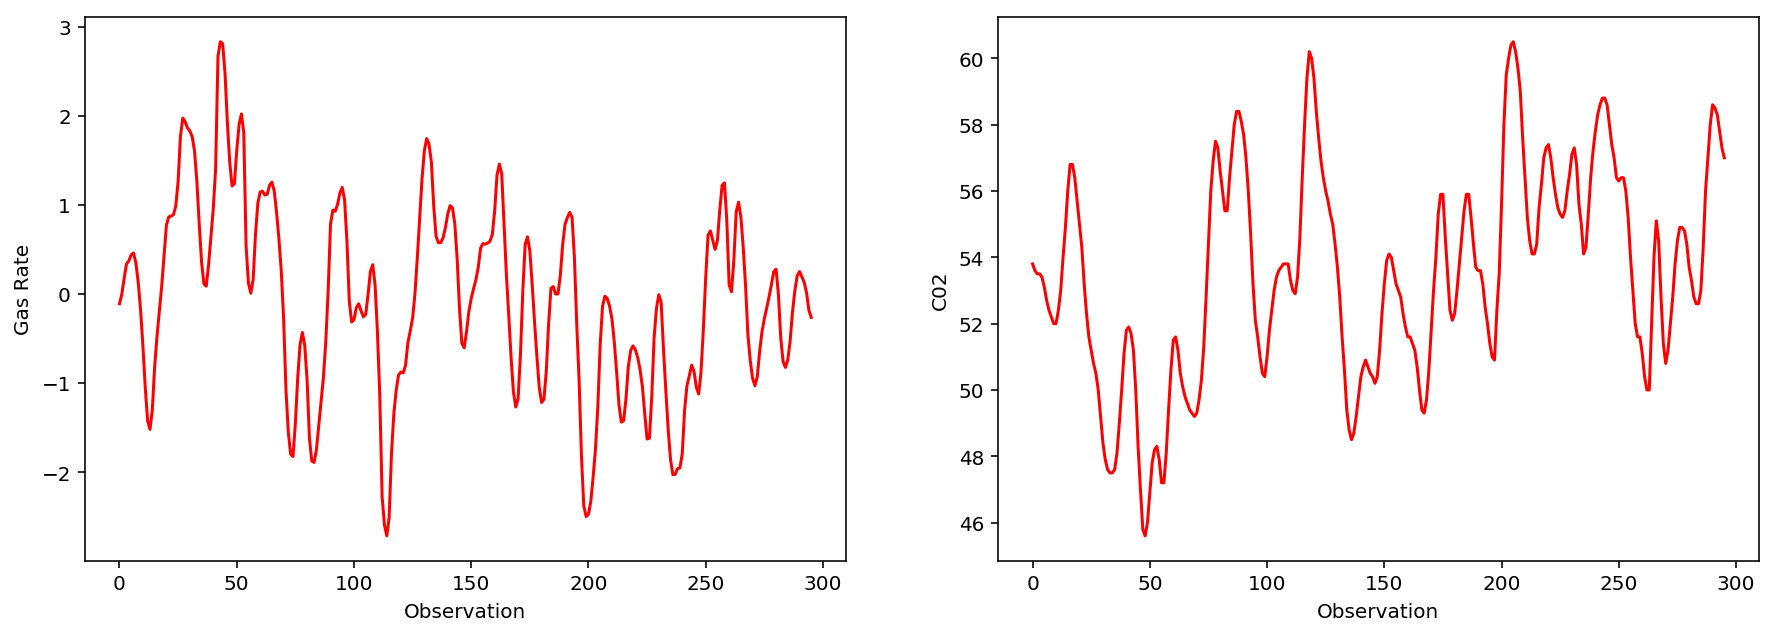

In [3]:
## 可视化两列数据
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
datadf.GasRate.plot(c="r")
plt.xlabel("Observation")
plt.ylabel("Gas Rate")
plt.subplot(1,2,2)
datadf.C02.plot(c="r")
plt.xlabel("Observation")
plt.ylabel("C02")
plt.show()

In [4]:
## 前面百分之75做训练集，后面百分之25做测试集
trainnum = np.int(datadf.shape[0]*0.75)
traidata = datadf.iloc[0:trainnum,:]
testdata = datadf.iloc[trainnum:datadf.shape[0],:]
print(traidata.shape)
print(testdata.shape)

(222, 2)
(74, 2)


### 平稳时间序列建模ARIMAX

**1:单位根检验检验序列的平稳性**

**2:使用pf.ARIMAX()建立ARIMAX模型**

In [5]:
## 1:单位根检验检验序列的平稳性,ADF 检验
dftest = sm.tsa.adfuller(datadf.GasRate,autolag='BIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
print("GasRate 检验结果：")
print(dfoutput)

dftest = sm.tsa.adfuller(datadf.C02,autolag='BIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
print("C02 检验结果：")
print(dfoutput)

GasRate 检验结果：
Test Statistic                  -4.878952
p-value                          0.000038
Lags Used                        2.000000
Number of Observations Used    293.000000
dtype: float64
C02 检验结果：
Test Statistic                  -2.947057
p-value                          0.040143
Lags Used                        3.000000
Number of Observations Used    292.000000
dtype: float64


**p-value均小于0.05，说明在置信度为95％水平下，两个序列均是平稳序列。**

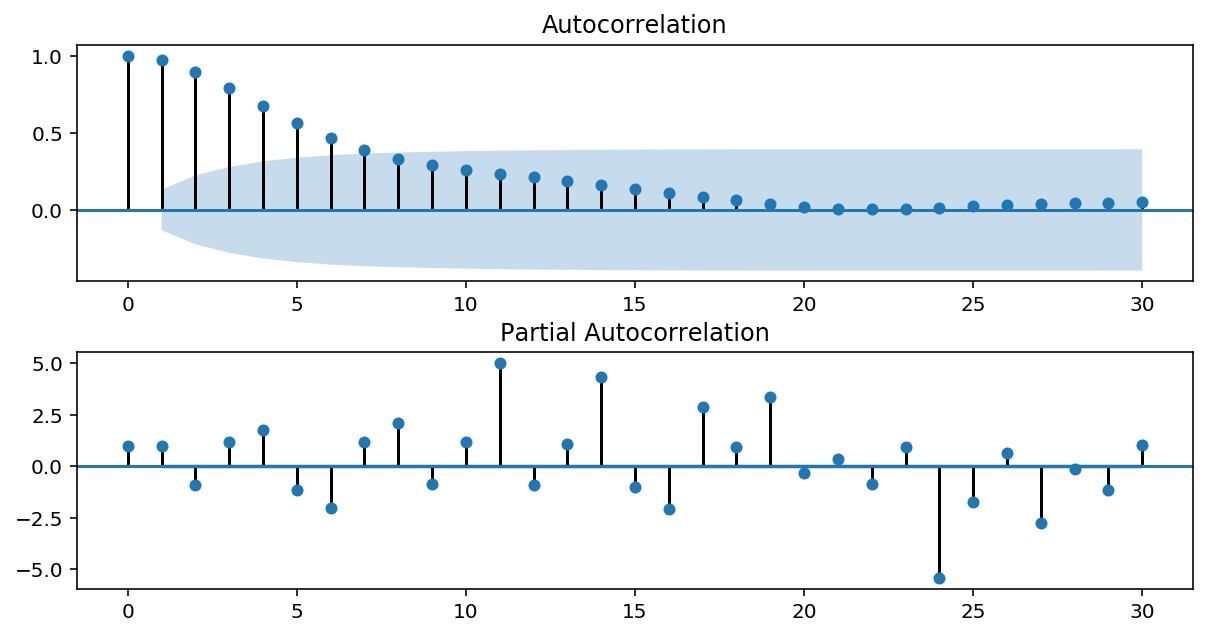

In [24]:
## 可视化序列的自相关和偏相关图
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(traidata.C02, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(traidata.C02, lags=30, ax=ax2)
plt.subplots_adjust(hspace = 0.3)
plt.show()

In [6]:
## 建立ARIMAX（1，0，2）模型
model  = pf.ARIMAX(data=traidata,formula="C02~GasRate",ar=1,ma=2,integ=0)
model_1 = model.fit("MLE")
model_1.summary()

Normal ARIMAX(1,0,2)                                                                                      
======================================================= ==================================================
Dependent Variable: C02                                 Method: MLE                                       
Start Date: 2                                           Log Likelihood: -71.9362                          
End Date: 221                                           AIC: 155.8725                                     
Number of observations: 220                             BIC: 176.2343                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9086     0.0191     47.5425  0.0      (0.8712 | 0.9461)        
MA(1)                                

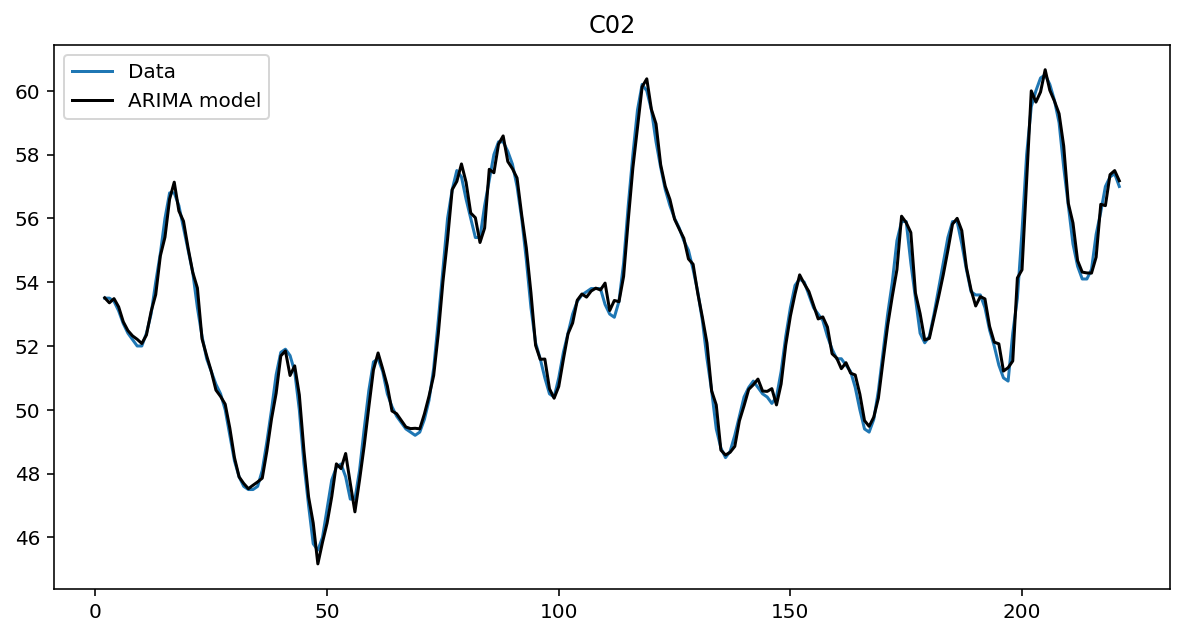

In [7]:
## 可视化模型在训练集上的拟合情况
model.plot_fit(figsize=(10,5))

可以发现在训练集上模型的拟合效果很好。

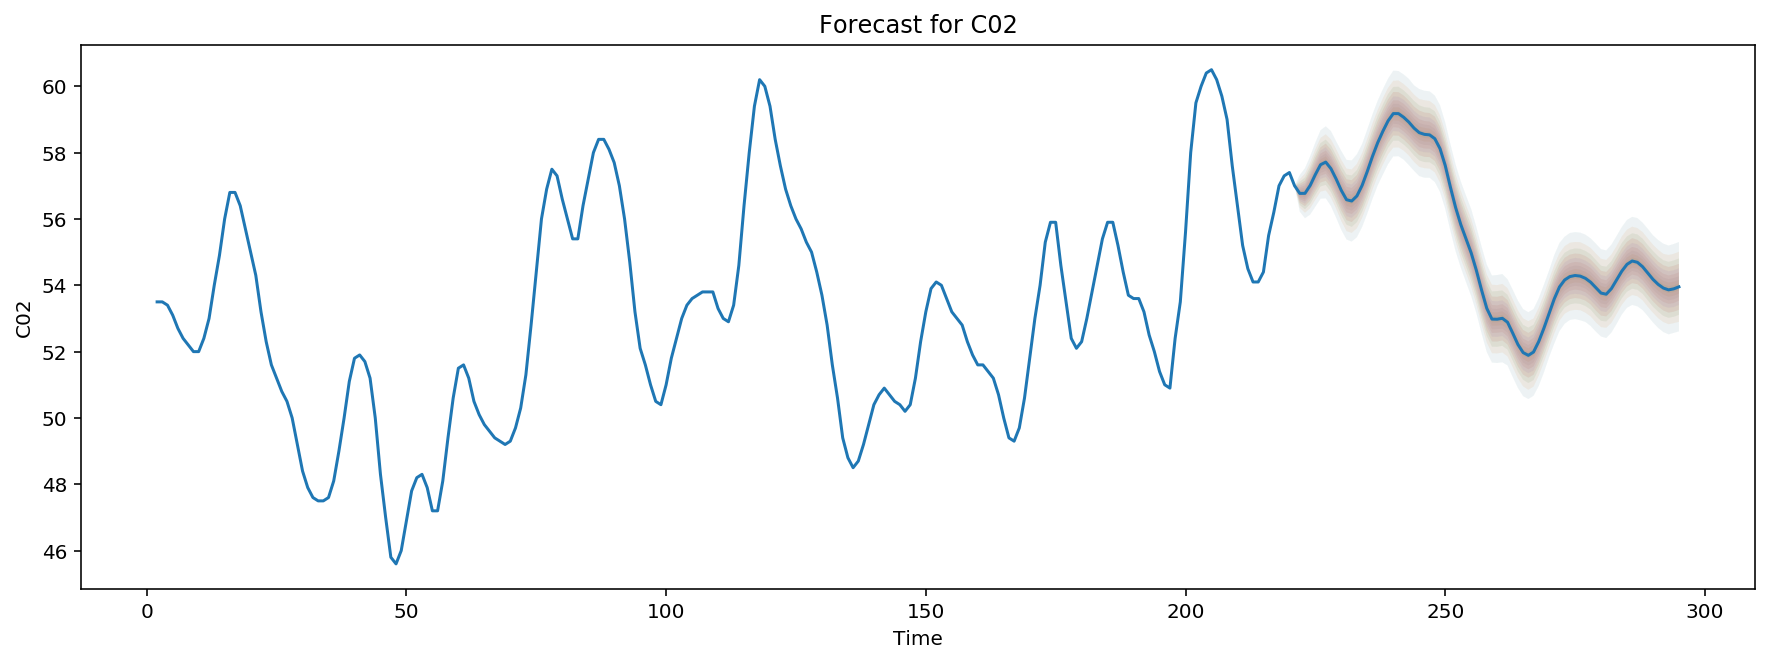

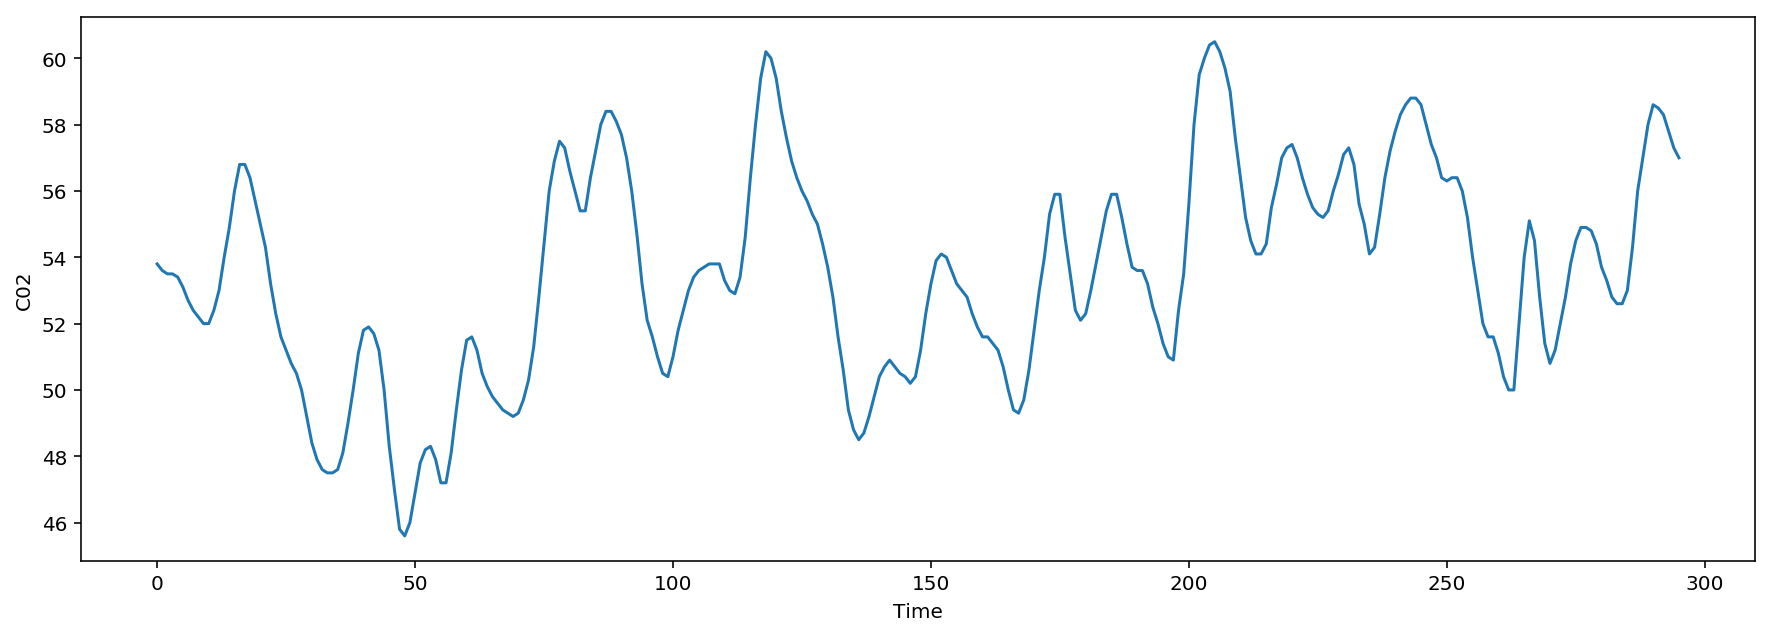

In [8]:
## 可视化模型的在测试集上的预测结果
model.plot_predict(h=testdata.shape[0], ## 往后预测多少步
                   oos_data=testdata,  ## 测试数据集
                   past_values=traidata.shape[0], ## 图像显示训练集的多少数据 
                   figsize=(15,5))
## 可视化原始数据
datadf.C02.plot(figsize=(15,5))
plt.xlabel("Time")
plt.ylabel("C02")
plt.show()

In [9]:
## 预测新的数据
C02pre = model.predict(h=testdata.shape[0], ## 往后预测多少步
                       oos_data=testdata,  ## 测试数据集
                       intervals=True, ## 同时预测置信区间
                      )
print("在测试集上mean absolute error:",mean_absolute_error(testdata.C02,C02pre.C02))
print("在测试集上mean squared error:",mean_squared_error(testdata.C02,C02pre.C02))
C02pre.head()

在测试集上mean absolute error: 1.5731456243696424
在测试集上mean squared error: 3.8376299478820215


,C02,1% Prediction Interval,5% Prediction Interval,95% Prediction Interval,99% Prediction Interval
222,56.770585,55.977370,56.220385,57.322349,57.569093
223,56.772237,55.713803,56.028345,57.506208,57.812247
224,57.009510,55.774585,56.135644,57.879974,58.236531
225,57.339511,55.992871,56.365061,58.294204,58.713362
226,57.635704,56.108393,56.575505,58.661231,59.100172


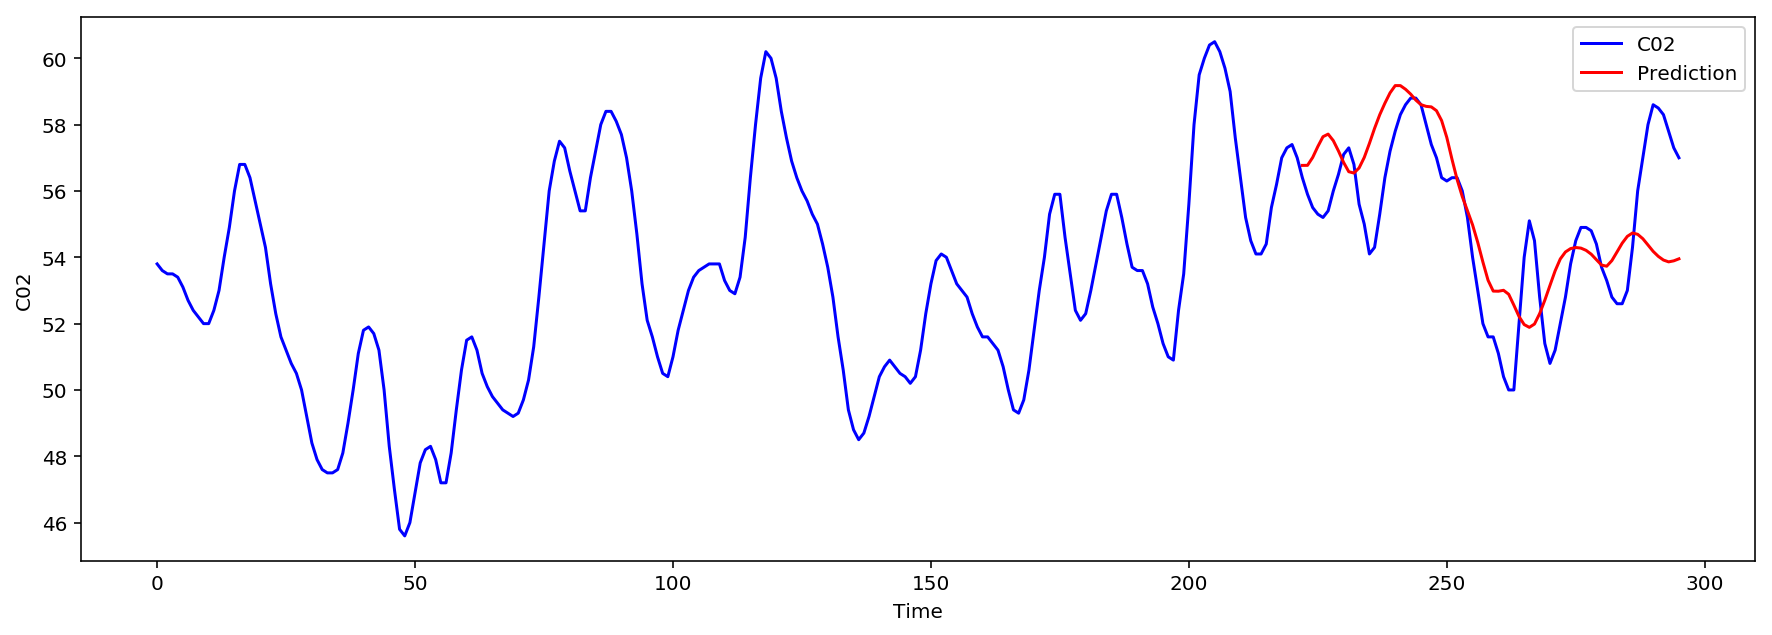

In [10]:
## 可视化原始数据和预测数据进行对比
datadf.C02.plot(figsize=(15,5),c="b",label="C02")
C02pre.C02.plot(c = "r",label="Prediction")
plt.xlabel("Time")
plt.ylabel("C02")
plt.legend(loc=0)
plt.show()

可以发现模型在趋势上预测准确，但是在精度上还有待改进

### 寻找合适的P，Q

In [11]:
p = np.arange(6)
q = np.arange(6)
pp,qq = np.meshgrid(p,q)
resultdf = pd.DataFrame(data = {"arp":pp.flatten(),"mrq":qq.flatten()})
resultdf["bic"] = np.double(pp.flatten())
resultdf["mae"] = np.double(qq.flatten())
## 迭代循环建立多个模型
for ii in resultdf.index:
    model_i = pf.ARIMAX(data=traidata,formula="C02~GasRate",ar=resultdf.arp[ii],ma=resultdf.mrq[ii],integ=0)
    try: 
        modeli_fit = model_i.fit("MLE")
        bic = modeli_fit.bic
        C02_pre = model.predict(h=testdata.shape[0],oos_data=testdata)
        mae = mean_absolute_error(testdata.C02,C02_pre.C02)
    except:
        bic = np.nan
    resultdf.bic[ii] = bic
    resultdf.mae[ii] = mae
print("模型迭代结束")

模型迭代结束


In [12]:
## 按照BIC寻找合适的模型
resultdf.sort_values(by="bic").head()

,arp,mrq,bic,mae
10,4,1,0.835035,1.573146
15,3,2,0.847907,1.573146
17,5,2,21.192451,1.573146
27,3,4,34.225353,1.573146
28,4,4,46.185878,1.573146


In [16]:
## 重新建立效果较好的模型
model  = pf.ARIMAX(data=traidata,formula="C02~GasRate",ar=4,ma=1,integ=0)
model_1 = model.fit("MLE")
model_1.summary()

Normal ARIMAX(4,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: C02                                 Method: MLE                                       
Start Date: 4                                           Log Likelihood: 21.1205                           
End Date: 221                                           AIC: -26.2409                                     
Number of observations: 218                             BIC: 0.835                                        
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    2.4472     0.0647     37.8416  0.0      (2.3205 | 2.574)         
AR(2)                                

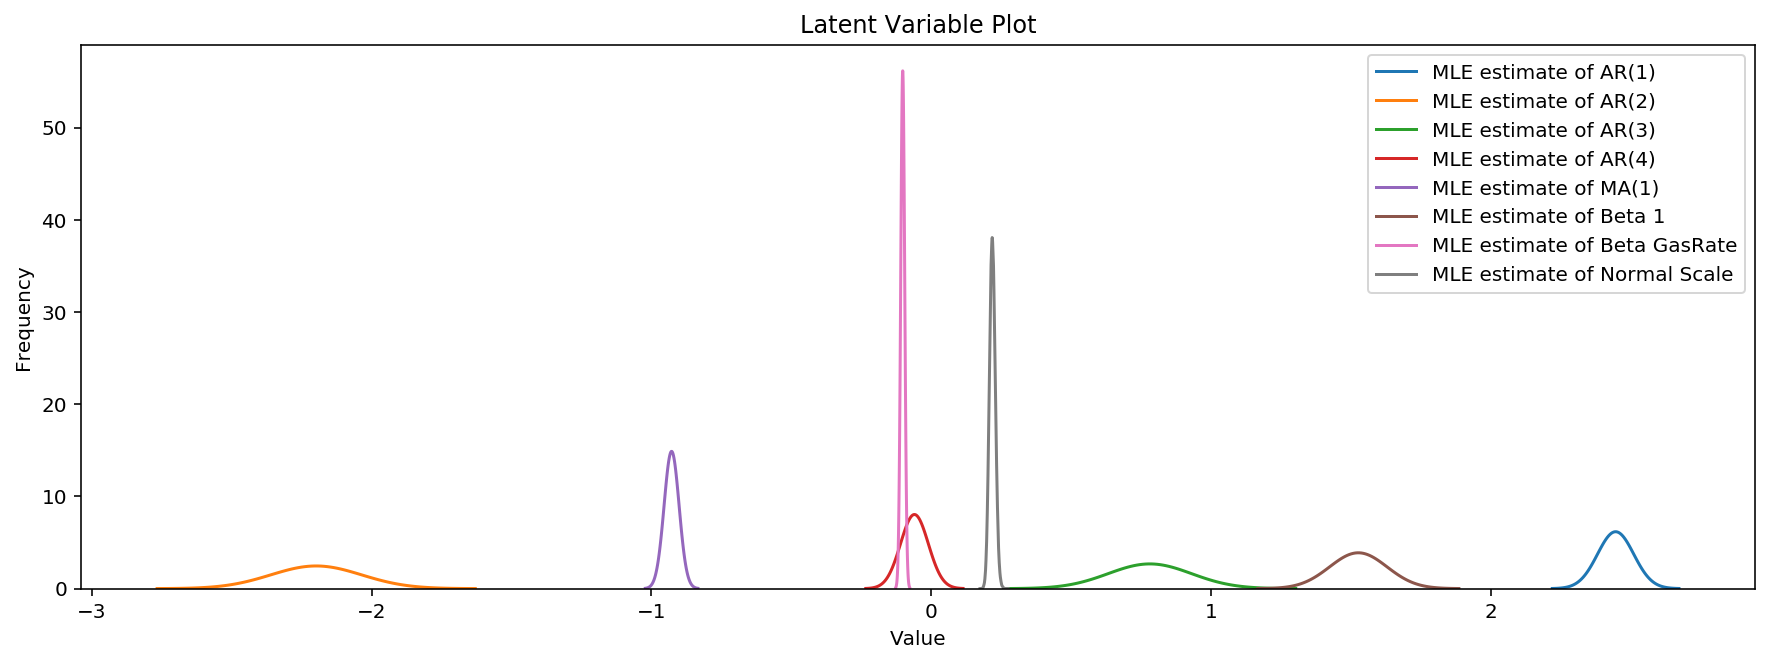

In [17]:
## 可视化潜在变量
model.plot_z()

在测试集上mean absolute error: 1.0976422694619847


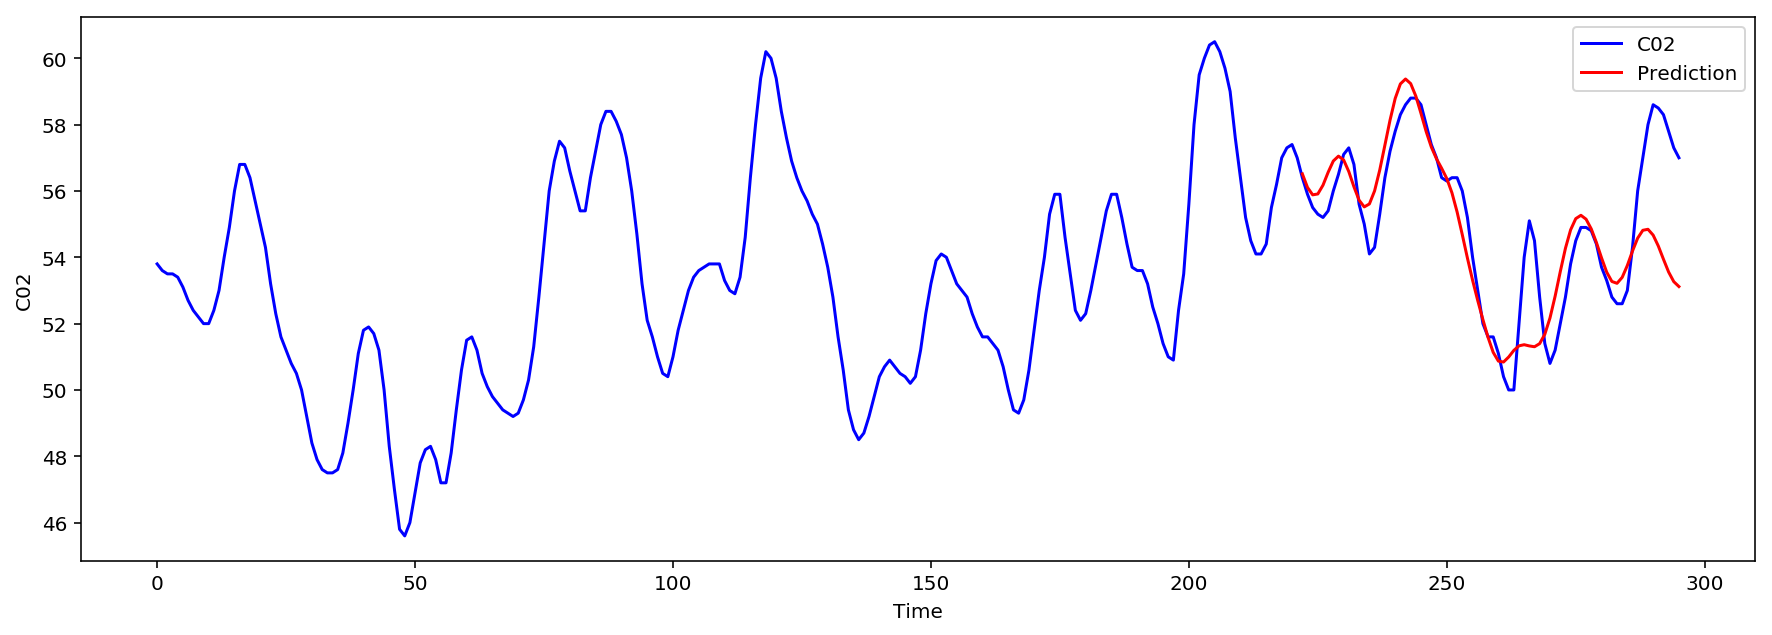

In [18]:
## 预测新的数据
C02pre = model.predict(h=testdata.shape[0], ## 往后预测多少步
                       oos_data=testdata,  ## 测试数据集
                      )
print("在测试集上mean absolute error:",mean_absolute_error(testdata.C02,C02pre.C02))
## 可视化原始数据和预测数据进行对比
datadf.C02.plot(figsize=(15,5),c="b",label="C02")
C02pre.C02.plot(c = "r",label="Prediction")
plt.xlabel("Time")
plt.ylabel("C02")
plt.legend(loc=0)
plt.show()